# Simulating Saturn's rings

In this example, we will simulate a small patch of Saturn's rings. The simulation is similar to the C example in `examples/shearing_sheet`.

We first import REBOUND and numpy, then create an instance of the Simulation class to work with.

In [2]:
import rebound
import numpy as np
sim = rebound.Simulation()

Next up, setting up several constants. We will be simulating a shearing sheet, a box with shear-periodic boundary conditions. This is a local approximation which makes the approximation that the epicyclic frequency $\Omega$ is the same for all particles. 

We work with a value of $\Omega$ that corresponds to a semi-major axis of $a\sim 130000$ km. 

In [3]:
OMEGA = 0.00013143527     # [1/s]

Next, we need to let REBOUND know about $\Omega$. Within REBOUND $\Omega$ is used by the integrator SEI, the Symplectic Epicycle Integrator (see Rein and Tremaine 2012).

In [4]:
sim.ri_sei.OMEGA = OMEGA

Finally, let us define the surface density of the ring and the particle density.

In [5]:
surface_density = 400.    # kg/m^2
particle_density = 400.   # kg/m^3

The gravitational constant in SI units is

In [6]:
sim.G = 6.67428e-11       # N m^2 / kg^2

We choose a timestep of 1/1000th of the orbital period.

In [7]:
sim.dt = 1e-3*2.*np.pi/OMEGA

We enable gravitational softening to smear out any potential numerical artifacts at very small scales.

In [8]:
sim.softening = 0.2       # [m]

Next up, we configure the simulation box. By default, REBOUND used no boundary conditions, but here we have shear periodic boundaries and a finite simulation domain, so we need to let REBOUND know about the simulation boxsize (note that it is significantly smaller than $a$, so our local approximation is very good. In this example we'll work in SI units.

In [9]:
boxsize = 200000.            # [m]
sim.configure_box(boxsize)

Because we have shear-periodic boundary conditions, we use ghost boxes to simulate the gravity of neighbouring ring patches. The more ghostboxes we use, the smoother the gravitational force across the boundary. Here, two layers of ghost boxes in the x and y direction are enough (this is a total of 24 ghost boxes). We don't need ghost boxes in the z direction because a ring is a two-dimensional system.

In [10]:
sim.configure_ghostboxes(2,2,0)

We can now setup which REBOUND modules we want to use for our simulation. Besides the SEI integrator and the shear-periodic boundary conditions mentioned above, we select the tree modules for both gravity and collisions. This speeds up the code from $O(N^2)$ to $O(N \log(N))$ for large numbers of particles $N$.

In [11]:
sim.integrator = "sei"
sim.boundary   = "shear"
sim.gravity    = "tree"
sim.collision  = "tree"
sim.collision_resolve = "hardsphere"

When two ring particles collide, they loose energy during their bounce. We here use a velocity dependent Bridges et al. coefficient of restitution. It is implemented as a python function (a C implementation would be faster!). We let REBOUND know which function we want to use by setting the `coefficient_of_restitution` function pointer in the simulation instance. 

In [12]:
def cor_bridges(r, v):
        eps = 0.32*pow(abs(v)*100.,-0.234)
        if eps>1.:
            eps=1.
        if eps<0.:
            eps=0.
        return eps
sim.coefficient_of_restitution = cor_bridges

To initialize the particles, we will draw random numbers from a power law distribution.

In [13]:
def powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

Now we can finally add particles to REBOUND. Note that we initialize particles so that they have initially no velocity relative to the mean shear flow.

In [14]:
total_mass = 0.
while total_mass < surface_density*(boxsize**2):
    radius = powerlaw(slope=-3, min_v=1, max_v=4)  # [m]    
    mass = particle_density*4./3.*np.pi*(radius**3)
    x = np.random.uniform(low=-boxsize/2., high=boxsize/2.)
    sim.add(
        m=mass,
        r=radius,
        x=x,
        y=np.random.uniform(low=-boxsize/2., high=boxsize/2.),
        z=np.random.normal(),
        vx = 0.,
        vy = -3./2.*x*OMEGA, 
        vz = 0.)
    total_mass += mass

To see what is going on in our simulation, we create a function to plot the current positions of particles and call it once to visualise the initial conditions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plotParticles(sim):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,aspect='equal')
    ax.set_ylabel("radial coordinate [m]")
    ax.set_xlabel("azimuthal coordinate [m]")
    ax.set_ylim(-boxsize/2.,boxsize/2.)
    ax.set_xlim(-boxsize/2.,boxsize/2.)

    for i, p in enumerate(sim.particles):
        circ = patches.Circle((p.y, p.x), p.r, facecolor='darkgray', edgecolor='black')
        ax.add_patch(circ)

plotParticles(sim)

NameError: name 'sim' is not defined

We now integrate for one orbital period $P=2\pi/\Omega$.

In [19]:
sim.integrate(1*(2.*np.pi/OMEGA))

The integration takes a few seconds, then we can visualise the final particle positions.

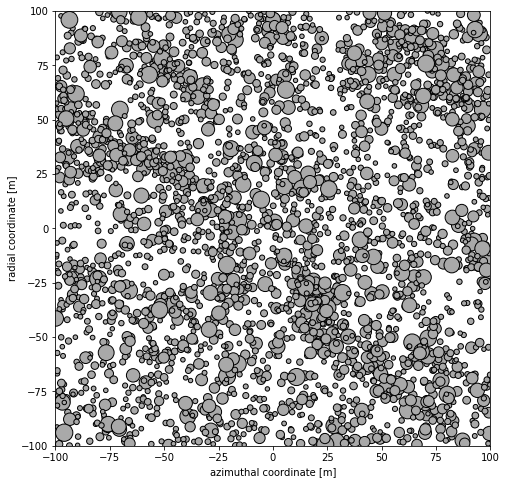

In [34]:
plotParticles(sim)

In [18]:
sim.status()

---------------------------------
REBOUND version:     	3.19.1
REBOUND built on:    	Jan 14 2022 11:24:53
Number of particles: 	1418
Selected integrator: 	sei
Simulation time:     	4.7804408262558332e+04
Current timestep:    	47.804408
---------------------------------
<rebound.particle.Particle object at 0x7fe6bc149940, m=5728.633726351226 x=-2.2529341204934252 y=38.294483126854985 z=7.325828330590892 vx=5.5826248428678545e-05 vy=0.0006673475054996795 vz=-0.000992074225284355>
<rebound.particle.Particle object at 0x7fe6bc1499c0, m=2509.5028860061007 x=48.693674913681 y=48.55329471143756 z=-8.270237374605818 vx=0.0032306419470869625 vy=-0.009507353469240094 vz=0.0005055762310672785>
<rebound.particle.Particle object at 0x7fe6bc149940, m=1910.5910875876516 x=69.00878387559395 y=-68.09998246213836 z=0.40866988670842025 vx=-0.0009138306145883995 vy=-0.013557329918040477 vz=-0.00021493644358922852>
<rebound.particle.Particle object at 0x7fe6bc1499c0, m=2278.362945300036 x=-91.5319777876297

Within just one orbital period, one can already see structure appearing on a scale close to the Toomre critical wavelength. The simulation will eventually settle down in a turbulent state where clumps constantly form, but then get destroyed again after a short time. Permanent clumping cannot occur because particles are inside the Roche limit.